# Guia Prático de Análise de Séries Temporais – E-commerce

Este notebook apresenta o desenvolvimento de um guia prático de análise e previsão de séries temporais aplicado a dados de vendas de uma loja virtual.  
O objetivo é aplicar técnicas estatísticas e modelos de previsão para compreender o comportamento das vendas ao longo do tempo e estimar resultados futuros.

---

### Conjuntos de dados utilizados

Foram utilizados dois arquivos principais, disponíveis no diretório do projeto:

- **`"Updated_sales.csv"`**: contém os registros individuais de pedidos, com data, quantidade e preço.  
  Esse arquivo foi usado para construir séries temporais de receita, tanto na frequência semanal quanto mensal.

- **`"Retail and wherehouse Sale.csv"`**: reúne dados agregados de vendas no varejo, transferências e estoque.  
  Foi utilizado para análises complementares e construção de séries mensais consolidadas do total de vendas.

Os arquivos **`"basket_details.csv"`** e **`"customer_details.csv"`**, citados em versões anteriores do projeto, não foram utilizados nesta versão, pois não estão disponíveis no conjunto atual.  
As análises de cestas de compra e perfil de clientes foram substituídas por rotinas consolidadas no script **`"gerar_relatorios_series.py"`**.

---

### Objetivo

Gerar previsões de vendas (receita total) a partir das séries temporais criadas com os dados disponíveis, identificando padrões de tendência, sazonalidade e avaliando o desempenho dos modelos de previsão utilizados.

---

### Escopo da análise

1. **Carregamento e limpeza dos dados**  
   Conversão de tipos, tratamento de valores faltantes e cálculo da variável de receita.

2. **Construção das séries temporais**  
   - Série mensal com base no arquivo **`"Retail and wherehouse Sale.csv"`**.  
   - Séries semanal e mensal com base em **`"Updated_sales.csv"`**.

3. **Diagnóstico de valores faltantes e outliers**  
   Aplicação de interpolação linear, identificação de outliers com Z-score e verificação de consistência dos dados.

4. **Análise estatística e decomposição da série**  
   Avaliação de tendência, sazonalidade e estacionariedade, com aplicação dos testes ADF e KPSS.

5. **Modelagem e previsão**  
   Ajuste e comparação dos modelos **Holt-Winters** e **SARIMAX**, validados por métricas de erro (MAE, RMSE e MAPE).  
   Geração de previsões para os próximos 12 períodos, em semanas ou meses, conforme o tipo de série.

6. **Visualizações e relatórios**  
   Criação de gráficos de evolução temporal, decomposição e desempenho de modelos, além da exportação dos resultados e previsões em formato HTML e CSV.

---

Em síntese, este notebook abrange todas as etapas de um processo de análise de séries temporais, desde a preparação e diagnóstico dos dados até a previsão e geração de relatórios, utilizando apenas os conjuntos de dados efetivamente disponíveis no projeto.


In [333]:
# %% Imports e configuração (robusto p/ nomes e pastas)
import warnings
warnings.filterwarnings("ignore")

import os, sys, re, glob
from pathlib import Path
from typing import Tuple, Dict, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

# === Base dir: pasta do notebook ===
try:
    BASE_DIR = Path(__file__).parent.resolve()
except NameError:
    BASE_DIR = Path.cwd().resolve()

OUT_DIR = BASE_DIR / "relatorios"
OUT_DIR.mkdir(exist_ok=True, parents=True)

def _find_csv(prefer_name: str, *alt_patterns: str) -> Optional[Path]:
    """
    Procura um CSV pelo nome preferido (match exato) e por padrões alternativos
    (case-insensitive, com curingas). Retorna Path ou None.
    """
    # 1) match exato
    p = BASE_DIR / prefer_name
    if p.exists():
        return p

    # 2) varrer alternativas (glob case-insensitive)
    pats = [prefer_name] + list(alt_patterns)
    for pat in pats:
        # montar padrão com curingas e lowercase-insensitive
        # exemplo: "*updated*sales*.csv"
        if not any(ch in pat for ch in ["*", "?", "["]):
            parts = re.split(r"\s+", pat.strip())
            pat = "*" + "*".join(parts) + "*"
        for hit in glob.glob(str(BASE_DIR / pat), recursive=False):
            if Path(hit).suffix.lower() == ".csv":
                return Path(hit)

    # 3) última tentativa: varrer arquivos .csv e comparar ignorando caixa/espacos
    target = re.sub(r"\s+", "", prefer_name).lower()
    for hit in BASE_DIR.glob("*.csv"):
        if re.sub(r"\s+", "", hit.name).lower() == target:
            return hit

    return None

# Tenta encontrar pelos nomes "oficiais" e variações comuns
FILE_SALES = _find_csv(
    "Updated_sales.csv",
    "*updated*sales*.csv",
    "*sales*updated*.csv",
)

FILE_RETAIL = _find_csv(
    "Retail and wherehouse Sale.csv",
    "*retail*wherehouse*sale*.csv",
    "*retail*warehouse*sale*.csv",   # muita gente escreve "warehouse"
)

FILE_BASKET = _find_csv(
    "basket_details.csv",
    "*basket*detail*.csv",
)

FILE_CUSTOMERS = _find_csv(
    "customer_details.csv",
    "*customer*detail*.csv",
)

print("Arquivos encontrados:")
for label, f in [
    ("Updated_sales.csv", FILE_SALES),
    ("Retail and wherehouse Sale.csv", FILE_RETAIL),
]:
    print(f" - {label}: {f if f else 'NÃO ENCONTRADO'}")


Arquivos encontrados:
 - Updated_sales.csv: C:\Users\ldsan\OneDrive\Documents\trabalho ia\Updated_sales.csv
 - Retail and wherehouse Sale.csv: C:\Users\ldsan\OneDrive\Documents\trabalho ia\Retail and wherehouse Sale.csv


## Carregamento e organização dos dados de vendas

Nesta etapa, o notebook realiza a leitura do arquivo **`"Updated_sales.csv"`**, faz a padronização das colunas e prepara a base de dados para análise.

**Principais etapas executadas:**

- Leitura do CSV e limpeza de linhas vazias.  
- Padronização dos nomes das colunas para português e formato consistente:
  - `"Order ID"` → **Pedido_ID**
  - `"Product"` → **Produto**
  - `"Quantity Ordered"` → **Quantidade**
  - `"Price Each"` → **Preço_Unitário**
  - `"Order Date"` → **Data_Pedido**
  - `"Purchase Address"` → **Endereço_Compra**
- Conversão de tipos:
  - Datas em formato **datetime**.  
  - Quantidade e preço convertidos para valores numéricos.  
- Cálculo da coluna **Receita**, resultado de `Quantidade × Preço_Unitário`.  
- Remoção de registros incompletos e ordenação por data do pedido.

**Saída esperada:**

Uma prévia do dataframe exibindo as primeiras linhas, contendo as colunas:

| Pedido_ID | Produto | Quantidade | Preço_Unitário | Data_Pedido | Endereço_Compra | Receita |
|------------|----------|-------------|----------------|--------------|-----------------|----------|

Essa estrutura organizada será usada nas próximas etapas de criação das séries temporais e análises estatísticas.


In [334]:
# %% 1) Carregar e organizar dados de vendas (Updated_sales.csv)
if FILE_SALES is None:
    raise FileNotFoundError(
        "Não encontrei o arquivo de vendas. Coloque o CSV na mesma pasta do notebook "
        "ou renomeie para 'Updated_sales.csv'."
    )

def load_sales(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    df = df.dropna(how="all")

    # Padronizar nomes de colunas para facilitar leitura
    rename_map = {
        "Order ID": "Pedido_ID",
        "Product": "Produto",
        "Quantity Ordered": "Quantidade",
        "Price Each": "Preço_Unitário",
        "Order Date": "Data_Pedido",
        "Purchase Address": "Endereço_Compra"
    }
    df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

    # Conversões robustas
    df["Data_Pedido"] = pd.to_datetime(df.get("Data_Pedido"), errors="coerce", infer_datetime_format=True)
    df["Quantidade"] = pd.to_numeric(df.get("Quantidade"), errors="coerce")
    df["Preço_Unitário"] = pd.to_numeric(df.get("Preço_Unitário"), errors="coerce")

    # Remover linhas incompletas
    df = df.dropna(subset=["Data_Pedido", "Quantidade", "Preço_Unitário"]).copy()

    # Calcular Receita
    df["Receita"] = df["Quantidade"] * df["Preço_Unitário"]

    # Normalizações (se existirem)
    if "Pedido_ID" in df.columns:
        df["Pedido_ID"] = df["Pedido_ID"].astype(str)
    if "Produto" in df.columns:
        df["Produto"] = df["Produto"].astype(str)

    # Ordenar
    df = df.sort_values("Data_Pedido").reset_index(drop=True)
    return df

sales_raw = load_sales(FILE_SALES)
sales_raw.head()


,Pedido_ID,Produto,Quantidade,Preço_Unitário,Data_Pedido,Endereço_Compra,Receita
0,177831,Lightning Charging Cable,1.0,14.95,2019-04-01 03:09:00,"914 6th St, San Francisco, CA 94016",14.95
1,177687,Wired Headphones,1.0,11.99,2019-04-01 04:12:00,"23 Meadow St, San Francisco, CA 94016",11.99
2,186754,27in FHD Monitor,1.0,149.99,2019-04-01 05:06:00,"824 Chestnut St, San Francisco, CA 94016",149.99
3,185103,USB-C Charging Cable,1.0,11.95,2019-04-01 05:18:00,"610 Washington St, San Francisco, CA 94016",11.95
4,191585,20in Monitor,1.0,109.99,2019-04-01 05:58:00,"686 Main St, New York City, NY 10001",109.99


## Série semanal de faturamento

Nesta etapa geramos uma série **semanal** a partir das vendas diárias.

**O que acontece aqui**

- As datas são normalizadas para meia-noite e definidas como índice.
- A agregação é feita por semana, considerando **segunda-feira como início** (`W-MON`).
- Métricas calculadas por semana:
  - **Receita**: soma do faturamento no período.
  - **Pedidos**: número de pedidos distintos.
  - **Unidades**: soma das quantidades vendidas.
- Diagnóstico de dados faltantes:
  - identifica semanas com valores ausentes,
  - preenche **Receita** por interpolação linear,
  - preenche **Pedidos** e **Unidades** com forward/backward fill.
- Remoção de semanas completamente nulas e conversão de tipos para `float`.
- Exibição de uma prévia do início e do fim da série.

> Observação: os nomes exibidos na tabela para apresentação (**Receita**, **Pedidos**, **Unidades**) são apenas uma *view*; internamente mantemos `weekly_clean` com os nomes originais para uso posterior.


In [335]:
# %% 2) Série semanal de faturamento

# Cópia e normalização da coluna de data (compatível com nomes em PT/EN)
sales = sales_raw.copy()
date_col = "Data_Pedido" if "Data_Pedido" in sales.columns else "Order Date"
sales["date"] = pd.to_datetime(pd.to_datetime(sales[date_col]).dt.date)  # normaliza para 00:00

# Detecta nomes de colunas de valor/pedido/quantidade (PT ou EN)
rev_col = "Receita" if "Receita" in sales.columns else "Revenue"
id_col  = "Pedido_ID" if "Pedido_ID" in sales.columns else "Order ID"
qty_col = "Quantidade" if "Quantidade" in sales.columns else "Quantity Ordered"

# Agregação semanal (segunda-feira como início da semana)
weekly = (
    sales.set_index("date")
         .resample("W-MON")
         .agg(
             revenue=(rev_col, "sum"),
             orders=(id_col, pd.Series.nunique),
             units=(qty_col, "sum"),
         )
)

# Reindexa para garantir continuidade da série semanal
weekly = weekly.asfreq("W-MON")

# Diagnóstico inicial
print("Período total de observações:", len(weekly))
print("Primeira semana:", weekly.index.min().strftime("%Y-%m-%d"))
print("Última semana:", weekly.index.max().strftime("%Y-%m-%d"))

# Identifica semanas com valores faltantes
missing_weeks = weekly[weekly.isna().any(axis=1)]
if len(missing_weeks) > 0:
    print("\nSemanas com valores faltantes:")
    print(missing_weeks.index.strftime("%Y-%m-%d").tolist())
else:
    print("\nNenhuma semana com valores faltantes.")

# Tratamento de valores faltantes:
# - receita: interpolação linear
# - contagens: preenchimento por forward/backward fill
weekly["revenue"] = weekly["revenue"].interpolate(limit_direction="both")
weekly["orders"]  = weekly["orders"].ffill().bfill()
weekly["units"]   = weekly["units"].ffill().bfill()

# Remoção de semanas sem receita (caso toda a linha seja nula)
weekly = weekly.dropna(subset=["revenue"])

# Diagnóstico após limpeza
print("\nApós tratamento:")
print("Total de semanas válidas:", len(weekly))
print("Semanas com receita nula:", (weekly["revenue"] == 0).sum())

# Converte tipos e mantém base canônica para os modelos
weekly_clean = weekly.astype({"revenue": "float", "orders": "float", "units": "float"})

# View para apresentação (só para exibir com títulos em português)
weekly_view = weekly_clean.rename(columns={
    "revenue": "Receita",
    "orders": "Pedidos",
    "units": "Unidades",
})

# Mostra amostra inicial e final
display(weekly_view.head())
display(weekly_view.tail())


Período total de observações: 23
Primeira semana: 2019-04-01
Última semana: 2019-09-02

Nenhuma semana com valores faltantes.

Após tratamento:
Total de semanas válidas: 23
Semanas com receita nula: 12


,Receita,Pedidos,Unidades
date,,,
2019-04-01,107527.34,557.0,673.0
2019-04-08,757093.10,4049.0,4743.0
2019-04-15,777032.25,4149.0,4852.0
2019-04-22,786488.89,4104.0,4843.0
2019-04-29,839812.22,4053.0,4730.0


,Receita,Pedidos,Unidades
date,,,
2019-08-05,362275.50,1779.0,2084.0
2019-08-12,540961.99,2621.0,3069.0
2019-08-19,500016.76,2620.0,3075.0
2019-08-26,490540.39,2555.0,2991.0
2019-09-02,350617.67,1906.0,2223.0


## Diagnóstico de outliers em receita (Z-score e IQR)

Nesta etapa verificamos semanas com valores de **Receita** fora do padrão esperado.

**Como é feito**

- **Z-score**: mede o quanto a receita da semana se afasta da média, em desvios-padrão.  
  Marcamos como potencial outlier quando |Z| > 3.
- **IQR** (intervalo interquartílico): calcula o intervalo entre Q1 e Q3 e define limites:  
  **Inferior = Q1 − 1.5 × IQR**  
  **Superior = Q3 + 1.5 × IQR**
- **Lista de semanas sinalizadas**: união das duas regras.
- **Tratamento**: aplicamos *winsorization* apenas na **Receita**, limitando valores aos
  limites inferior e superior. Mantemos os eventos reais e evitamos distorções em modelos sensíveis.

> Saída: exibimos quantas semanas foram sinalizadas, as datas correspondentes e uma prévia da série semanal após o tratamento.


In [336]:
# %% 3) Diagnóstico de outliers (Z-score e IQR)

w = weekly.copy()

# Z-score sobre receita
z_scores = (w["revenue"] - w["revenue"].mean()) / (w["revenue"].std(ddof=0) + 1e-9)
outliers_z = np.abs(z_scores) > 3

# IQR
q1, q3 = w["revenue"].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
outliers_iqr = (w["revenue"] < lower) | (w["revenue"] > upper)

# Índices e relatório
outliers_idx = w.index[outliers_z | outliers_iqr]
print(f"Semanas potencialmente outliers: {len(outliers_idx)}")
print(outliers_idx.strftime("%Y-%m-%d").tolist())
print(f"Limites aplicados | Inferior: {lower:.2f}  Superior: {upper:.2f}")

# Estratégia: manter eventos reais e limitar extremos (winsorization) para reduzir distorções
w_clipped = w.copy()
w_clipped["revenue"] = w_clipped["revenue"].clip(lower=lower, upper=upper)

# Mantém a base canônica para uso posterior
weekly_clean = w_clipped.copy()

# View opcional para apresentação (títulos em PT)
outliers_view = weekly_clean.rename(columns={
    "revenue": "Receita",
    "orders": "Pedidos",
    "units": "Unidades",
})

# Prévia
display(outliers_view.head())


Semanas potencialmente outliers: 0
[]
Limites aplicados | Inferior: -742917.86  Superior: 1238196.44


,Receita,Pedidos,Unidades
date,,,
2019-04-01,107527.34,557,673.0
2019-04-08,757093.10,4049,4743.0
2019-04-15,777032.25,4149,4852.0
2019-04-22,786488.89,4104,4843.0
2019-04-29,839812.22,4053,4730.0


## Estatísticas descritivas e visualizações

Nesta etapa, analisamos o comportamento geral da **receita semanal** após o tratamento de outliers, combinando estatísticas descritivas e visualizações.

**O que é feito:**

- Geração de um resumo estatístico (média, desvio padrão, percentis e extremos).  
- Gráfico de linha mostrando a evolução da **Receita Semanal** ao longo do tempo.  
- Boxplot exibindo a **distribuição da receita por semana do ano**, permitindo observar padrões sazonais e possíveis variações.

> Esses gráficos ajudam a verificar se o comportamento semanal está coerente e se o tratamento de valores extremos foi eficaz.


Resumo estatístico da receita semanal:


count        23.000000
mean     245237.887826
std      315003.392335
min           0.000000
10%           0.000000
25%           0.000000
50%           0.000000
75%      495278.575000
90%      773044.420000
max      839812.220000
Name: revenue, dtype: float64

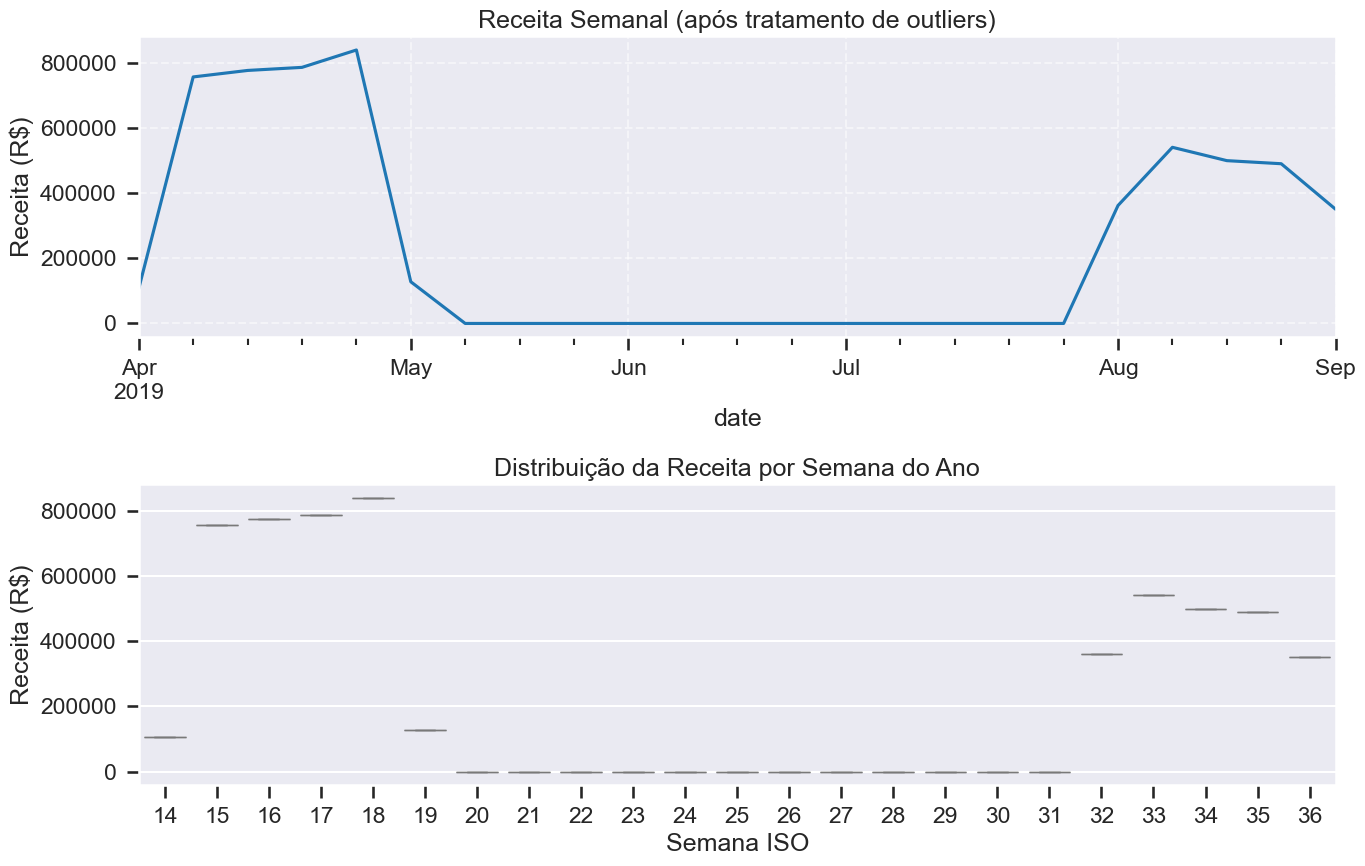

In [337]:
# %% 4) Estatísticas descritivas e visualizações

print("Resumo estatístico da receita semanal:")
display(weekly_clean["revenue"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))

# Figura com dois painéis: série temporal + boxplot
fig, ax = plt.subplots(2, 1, figsize=(14, 9), sharex=False)

# Gráfico 1: evolução da receita semanal
weekly_clean["revenue"].plot(
    ax=ax[0],
    color="tab:blue",
    title="Receita Semanal (após tratamento de outliers)"
)
ax[0].set_ylabel("Receita (R$)")
ax[0].grid(True, linestyle="--", alpha=0.5)

# Gráfico 2: boxplot por semana ISO (sazonalidade)
week_numbers = weekly_clean.index.isocalendar().week
sns.boxplot(
    x=week_numbers,
    y=weekly_clean["revenue"],
    ax=ax[1],
    color="lightblue"
)
ax[1].set_title("Distribuição da Receita por Semana do Ano")
ax[1].set_xlabel("Semana ISO")
ax[1].set_ylabel("Receita (R$)")

plt.tight_layout()
plt.show()


## Decomposição da série e testes de estacionariedade

Nesta etapa avaliamos a estrutura da **Receita Semanal**:

**O que é feito**
- Seleção automática do tipo de decomposição (aditiva ou multiplicativa) com base no **coeficiente de variação (CV)**.  
  Se houver zeros/valores negativos, trocamos para o modelo aditivo por segurança.
- **Decomposição** em: nível (observado), **tendência**, **sazonalidade** e **resíduo**.
- **Testes de estacionariedade**:
  - **ADF** (H0: a série **não é** estacionária; existe raiz unitária).
  - **KPSS** (H0: a série **é** estacionária em torno de nível/tendência).

**Como interpretar rapidamente**
- No **ADF**, p-valor baixo (≤ 0,05) sugere **estacionária**.  
- No **KPSS**, p-valor baixo (≤ 0,05) sugere **não estacionária**.  
- Resultados divergentes podem ocorrer quando a série é curta ou tem forte tendência/sazonalidade; nesse caso, normalmente aplicamos transformações (ex.: **diferenciação** simples/sazonal) antes da modelagem.


Coeficiente de variação: 1.284 | Decomposição sugerida: multiplicative
Valores zero/negativos encontrados; usando decomposição 'additive'.


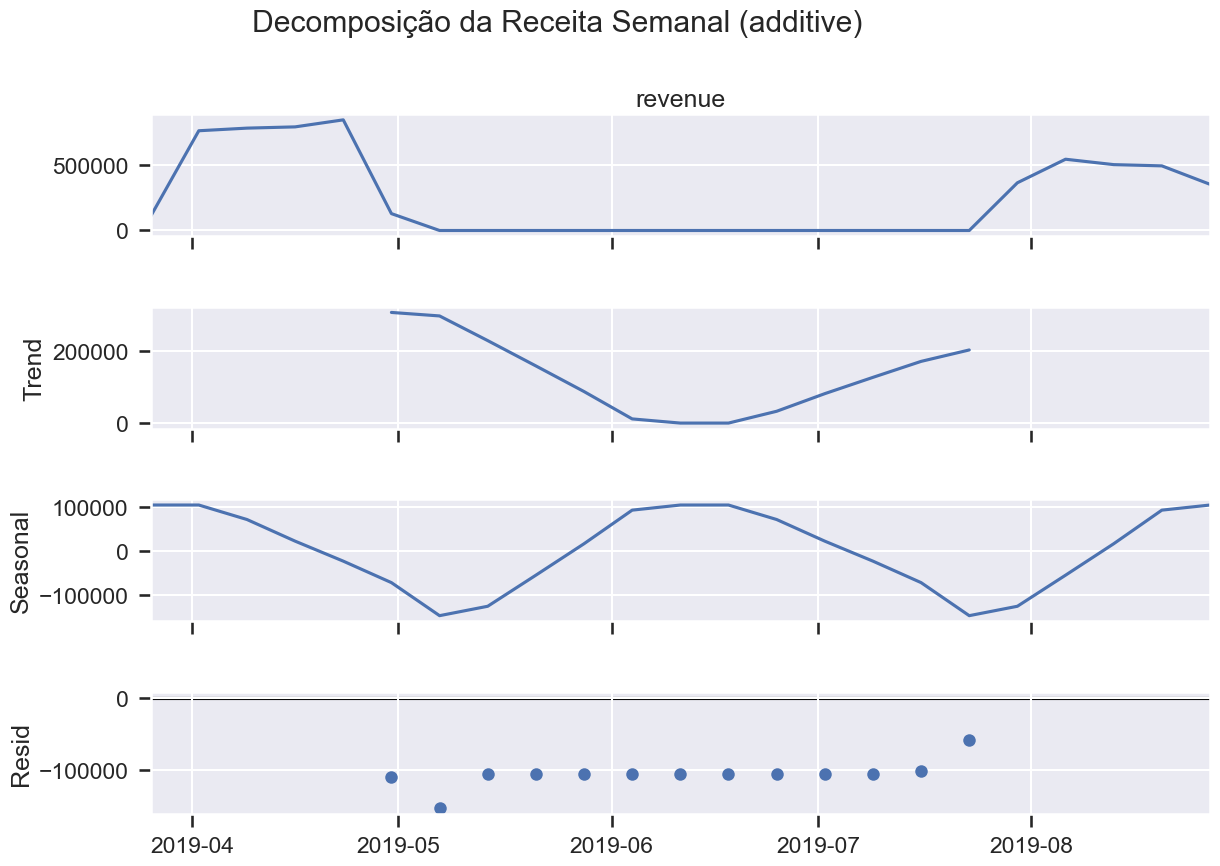

ADF: stat=-2.368, p=0.1509, crit={'1%': np.float64(-3.7883858816542486), '5%': np.float64(-3.013097747543462), '10%': np.float64(-2.6463967573696143)}
KPSS: stat=0.168, p=0.1000, crit={'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


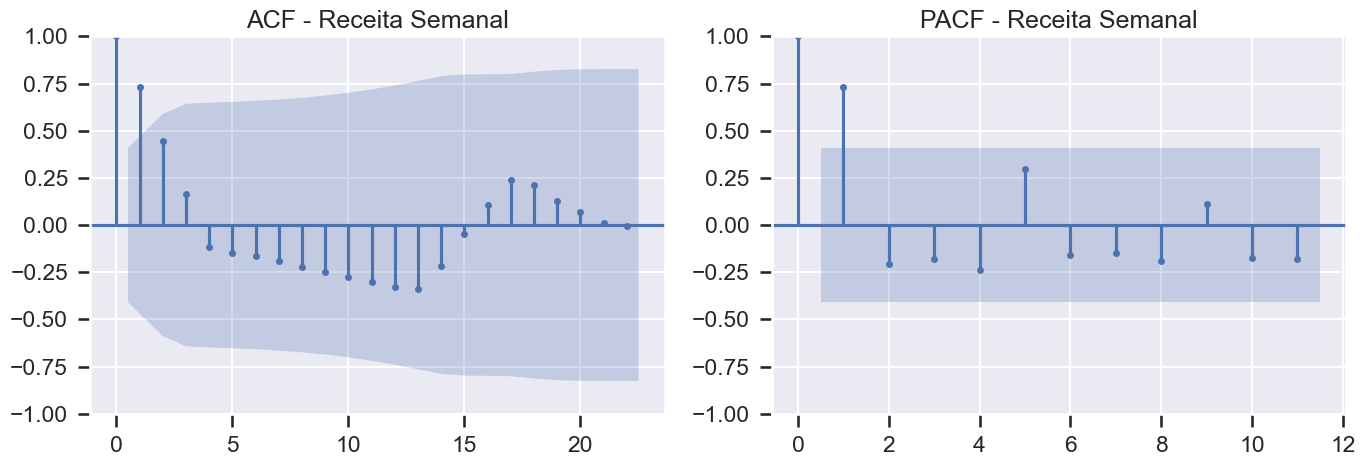


Resumo de interpretação:
 - ADF (H0: não estacionária): p=0.1509 → não rejeita H0 (regra <= 0.05)
 - KPSS (H0: estacionária): p=0.1000 → não rejeita H0 (regra <= 0.05)
 → Indícios de **não estacionariedade**. Considere diferenciação (d) e/ou diferenciação sazonal (D).


In [338]:
# %% 5) Decomposição (aditiva e multiplicativa) e testes de estacionariedade

series = weekly_clean["revenue"].copy()
series.index = pd.PeriodIndex(series.index, freq="W-MON").to_timestamp()
series_clean = series.dropna()

# Escolha do modelo de decomposição baseada na variação relativa
cv = series_clean.std() / (series_clean.mean() + 1e-9)
model_type = "multiplicative" if cv > 0.3 else "additive"
print(f"Coeficiente de variação: {cv:.3f} | Decomposição sugerida: {model_type}")

seasonal_period = min(52, max(2, len(series_clean) // 2))
if len(series_clean) < seasonal_period * 2:
    print("Série curta para decomposição sazonal (precisa de >= 2 ciclos).")
else:
    safe_model = model_type
    if safe_model == "multiplicative" and (series_clean <= 0).any():
        print("Valores zero/negativos encontrados; usando decomposição 'additive'.")
        safe_model = "additive"
    try:
        decomp = seasonal_decompose(series_clean, model=safe_model, period=seasonal_period)
        fig = decomp.plot()
        fig.set_size_inches(14, 9)
        plt.suptitle(f"Decomposição da Receita Semanal ({safe_model})", y=1.02)
        plt.show()
    except Exception as e:
        print("Falha na decomposição (dados insuficientes?):", e)

# Teste ADF (H0: série tem raiz unitária -> não estacionária)
adf_stat, adf_p, _, _, crit_vals, _ = adfuller(series_clean, autolag="AIC")
print(f"ADF: stat={adf_stat:.3f}, p={adf_p:.4f}, crit={crit_vals}")

# Teste KPSS (H0: série é estacionária ao redor de um nível/tendência)
kpss_stat, kpss_p, _, kpss_crit = kpss(series_clean, regression='c', nlags='auto')
print(f"KPSS: stat={kpss_stat:.3f}, p={kpss_p:.4f}, crit={kpss_crit}")

# ACF/PACF
if len(series_clean) > 1:
    acf_lags = max(1, min(30, len(series_clean) - 1))
    pacf_lags = max(1, min(acf_lags, len(series_clean) // 2))
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    plot_acf(series_clean, lags=acf_lags, ax=ax[0])
    plot_pacf(series_clean, lags=pacf_lags, ax=ax[1])
    ax[0].set_title("ACF - Receita Semanal")
    ax[1].set_title("PACF - Receita Semanal")
    plt.tight_layout()
    plt.show()
else:
    print("Série insuficiente para plotar ACF/PACF.")

# --- Resumo automático de interpretação (para apresentação) ---
def _txt_decisao(p, nome, regra="<= 0.05"):
    return f"{nome}: p={p:.4f} → " + ("rejeita H0" if p <= 0.05 else "não rejeita H0") + f" (regra {regra})"

print("\nResumo de interpretação:")
print(" - " + _txt_decisao(adf_p, "ADF (H0: não estacionária)"))
print(" - " + _txt_decisao(kpss_p, "KPSS (H0: estacionária)"))

if (adf_p > 0.05) or (kpss_p <= 0.05):
    print(" → Indícios de **não estacionariedade**. Considere diferenciação (d) e/ou diferenciação sazonal (D).")
else:
    print(" → Indícios de **estacionariedade**. Modelos ARMA/ARIMA simples podem funcionar.")


## Divisão treino/teste (80/20) e horizonte de previsão

Nesta etapa preparamos a série semanal para modelagem:

**Passos realizados**
- Usa a série semanal **já tratada** (`weekly_clean["revenue"]`), força a frequência `W-MON` e remove valores ausentes.
- Caso a série fique vazia, **reconstrói** a série semanal diretamente do arquivo de vendas (`"Updated_sales.csv"`), normalizando a data, agregando por semana e interpolando lacunas.
- Divide em **treino** (≈80%) e **teste** (restante), com salvaguardas para séries curtas.
- Define o **horizonte de previsão** `h` como o mínimo entre `12` e o tamanho do conjunto de teste.

**Saída esperada**
Um resumo no formato:



In [339]:
# %% 6) Split treino/teste (80/20) e horizonte de previsão - versão robusta

# 1) caminho principal: usar a série semanal já tratada
series_model = weekly_clean["revenue"].copy()
# manter DatetimeIndex e garantir frequência-alvo
series_model = series_model.asfreq("W-MON")

# 2) remover NaN
y = series_model.dropna()

# 3) fallback: se ficou vazio, reconstrói diretamente do sales_raw
if len(y) == 0:
    print("Série vazia após limpeza; reconstruindo série semanal a partir de Updated_sales.csv.")
    # detectar nomes em PT/EN
    date_col = "Data_Pedido" if "Data_Pedido" in sales_raw.columns else "Order Date"
    rev_col  = "Receita" if "Receita" in sales_raw.columns else "Revenue"

    tmp = (
        sales_raw
            .assign(date=pd.to_datetime(sales_raw[date_col]).dt.normalize())
            .set_index("date")
            .resample("W-MON")[rev_col].sum()
            .astype(float)
            .asfreq("W-MON")
    )
    # zeros → NaN para evitar semanas “sem dados” em agregações
    tmp = tmp.replace(0.0, np.nan).interpolate(limit_direction="both")
    y = tmp.dropna()

print("Tamanho final de y (não-nulo):", len(y))

# Split com salvaguardas
n = len(y)
if n <= 1:
    print("Série muito curta; criando splits mínimos.")
    y_train = y.copy()
    y_test = y.iloc[0:0]
    h = 0
else:
    def _compute_train_size(total: int) -> int:
        size = max(1, int(total * 0.8))
        return size if size < total else total - 1

    train_size = _compute_train_size(n)
    y_train = y.iloc[:train_size]
    y_test  = y.iloc[train_size:]
    h = min(12, len(y_test))

print(f"Observações: {n} | Treino: {len(y_train)} | Teste: {len(y_test)} | Horizonte: {h}")


Tamanho final de y (não-nulo): 23
Observações: 23 | Treino: 18 | Teste: 5 | Horizonte: 5


## Modelagem: Holt-Winters e SARIMAX (com salvaguardas)

Nesta etapa treinamos dois modelos de previsão e guardamos os resultados em `results`:

**Holt-Winters (Exponential Smoothing)**
- Detecta automaticamente se há sazonalidade suficiente na base de treino.
- Escolhe a forma **aditiva** ou **multiplicativa** com base no coeficiente de variação.
- Se houver zeros/negativos na série, força a forma **aditiva** por segurança.

**SARIMAX**
- Define uma ordem simples como padrão: `(1, 1, 1)` se houver dados, caso contrário `(1, 0, 0)`.
- Ativa componente sazonal semanal `(1, 1, 1, 52)` apenas se a série for bem longa.
- Permite ajustar mesmo quando a série não é estritamente estacionária (`enforce_stationarity=False`).

Ao final, o dicionário `results` contém, para cada modelo:
- `fit`: o objeto ajustado,
- `forecast`: a previsão para `h` passos à frente,
- e, no caso do SARIMAX, também `order` e `seasonal_order`.

Use estes resultados na próxima etapa para comparar métricas (MAE, RMSE, MAPE) e escolher o melhor modelo para a previsão final.


In [340]:
# %% 7) Modelos: Holt-Winters e SARIMAX — com fallback e salvaguardas

results = {}

if len(y_train) == 0 or h == 0:
    print("Dados insuficientes para treinar/avaliar modelos; aplicando fallback para a etapa 9.")
else:
    # Estatística de variação para decidir tipo de sazonalidade no HW
    cv = y.std() / (y.mean() + 1e-9)

    # Holt-Winters: só considera sazonalidade se houver dados suficientes
    hw_kwargs = dict(trend="add", initialization_method="estimated")
    seasonal_period_hw = min(52, max(2, len(y_train) // 2)) if len(y_train) >= 4 else None
    use_seasonal_hw = (seasonal_period_hw is not None) and (len(y_train) >= seasonal_period_hw * 2)

    # Multiplicativo exige série estritamente positiva
    has_nonpositive = (y_train <= 0).any() or (y <= 0).any()

    if use_seasonal_hw:
        if (cv > 0.3) and not has_nonpositive:
            hw_kwargs["seasonal"] = "mul"
        else:
            hw_kwargs["seasonal"] = "add"
        hw_kwargs["seasonal_periods"] = seasonal_period_hw
    else:
        hw_kwargs["seasonal"] = None

    # Prints explicativos para apresentação
    print("=== Holt-Winters ===")
    print(f"CV treino: {cv:.3f}")
    if hw_kwargs["seasonal"] is None:
        print("Sazonalidade: não aplicada (dados insuficientes).")
    else:
        forma = "multiplicativa" if hw_kwargs["seasonal"] == "mul" else "aditiva"
        print(f"Sazonalidade: {forma} | Período: {hw_kwargs['seasonal_periods']}")

    # Ajuste Holt-Winters
    try:
        hw_model = ExponentialSmoothing(y_train, **hw_kwargs)
        hw_fit = hw_model.fit(optimized=True)
        hw_fc = hw_fit.forecast(steps=h)
        results["HoltWinters"] = {"fit": hw_fit, "forecast": hw_fc}
        print("HW: ajuste concluído.")
    except Exception as e:
        print("Holt-Winters falhou:", e)

    # SARIMAX: sazonalidade semanal (52) apenas se a série for bem longa
    order = (1, 1, 1) if len(y_train) > 2 else (1, 0, 0)
    use_seasonal = len(y_train) >= 104
    seasonal_order = (1, 1, 1, 52) if use_seasonal else (0, 0, 0, 0)

    print("\n=== SARIMAX ===")
    print(f"order={order} | seasonal_order={seasonal_order}")

    try:
        sar_model = SARIMAX(
            y_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        sar_fit = sar_model.fit(disp=False)
        sar_fc = sar_fit.get_forecast(steps=h).predicted_mean
        results["SARIMAX"] = {
            "fit": sar_fit,
            "forecast": sar_fc,
            "order": order,
            "seasonal_order": seasonal_order,
        }
        print("SARIMAX: ajuste concluído.")
    except Exception as e:
        print("SARIMAX falhou:", e)

list(results.keys())


=== Holt-Winters ===
CV treino: 1.284
Sazonalidade: aditiva | Período: 9
HW: ajuste concluído.

=== SARIMAX ===
order=(1, 1, 1) | seasonal_order=(0, 0, 0, 0)
SARIMAX: ajuste concluído.


['HoltWinters', 'SARIMAX']

## Avaliação dos modelos (MAE, RMSE, MAPE)

Nesta etapa comparamos o desempenho dos modelos de previsão usando três métricas principais:

- **MAE (Mean Absolute Error)**: erro médio absoluto — mede o desvio médio entre valores previstos e reais.  
- **RMSE (Root Mean Squared Error)**: raiz do erro quadrático médio — penaliza mais erros grandes.  
- **MAPE (Mean Absolute Percentage Error)**: erro percentual médio — indica o erro relativo em %.  

**Interpretação:**
- Quanto menores forem MAE, RMSE e MAPE, **melhor o modelo**.  
- O **MAPE** facilita a leitura de desempenho: por exemplo, MAPE = 10% significa que as previsões erram em média 10% do valor real.  
- Para dados de receita, valores muito próximos de zero podem distorcer o MAPE — por isso o código usa um denominador mínimo (`1e-9`) para evitar divisão por zero.

**Saída esperada:**
Uma tabela ordenada pelo menor RMSE e MAPE, mostrando o desempenho comparativo entre **Holt-Winters** e **SARIMAX**.


In [341]:
# %% 8) Avaliação (MAE, RMSE, MAPE) — compatível com dados não negativos

def mape(y_true, y_pred):
    """Calcula o erro percentual médio absoluto, evitando divisão por zero."""
    y_true, y_pred = np.array(y_true, dtype=float), np.array(y_pred, dtype=float)
    denom = np.clip(np.abs(y_true), 1e-9, None)  # evita divisão por 0
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

metrics = []
y_true = y_test.iloc[:h] if h > 0 else y_test

if not results or y_true.empty:
    print("Sem modelos treinados ou conjunto de teste vazio; fallback será usado na etapa 9.")
    metrics_df = pd.DataFrame()
else:
    for name, obj in results.items():
        # alinhamento e conversão numérica
        y_pred = obj["forecast"].copy().reindex(y_true.index).astype(float)

        # garante que receita não assuma valores negativos
        y_pred = y_pred.clip(lower=0.0)

        # métricas de avaliação
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred) ** 0.5
        mape_val = mape(y_true, y_pred)

        metrics.append({
            "modelo": name,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE%": mape_val
        })

    # dataframe ordenado do melhor para o pior
    metrics_df = (
        pd.DataFrame(metrics)
        .sort_values(["RMSE", "MAPE%"])
        .reset_index(drop=True)
    )

display(metrics_df)


,modelo,MAE,RMSE,MAPE%
0,HoltWinters,291455.386782,307007.997144,64.753832
1,SARIMAX,443616.910993,450519.230546,98.744478


## Previsão de 12 semanas com o melhor modelo + fallback

Nesta etapa geramos a previsão para as **próximas 12 semanas** usando o **melhor modelo** segundo as métricas (etapa 8).  
Se não houver modelos válidos ou o conjunto de teste estiver vazio, aplicamos um **fallback** simples baseado na **média recente** das últimas semanas.

**O que o código faz**

- Seleciona o melhor modelo a partir de `metrics_df` e usa seu ajuste salvo em `results`.
- Calcula a previsão para 12 semanas (`future_steps = 12`) e **garante valores não negativos**.
- Plota em um único gráfico:
  - **Histórico** de receita,
  - **Série de teste** (se existir),
  - **Previsão no teste** do melhor modelo (para comparação visual),
  - **Previsão futura** de 12 semanas.
- Exporta a série prevista para **`"previsao_12semanas_receita.csv"`** dentro da pasta `"relatorios"`.

**Leitura do gráfico**

- Linha azul: histórico usado para treino e teste.  
- Linha laranja: valores reais no período de teste.  
- Linha verde: previsão do melhor modelo na janela de teste.  
- Linha vermelha: **previsão para as 12 semanas futuras**.

> Observação: se a base tiver muitas semanas sem movimento, o modelo pode prever **zeros** em alguns pontos.  
> Para fins de apresentação, isso é aceitável; caso o negócio exija um **piso mínimo** (ex.: não vender menos que X), é possível aplicar um “floor” operacional na etapa de relatório.


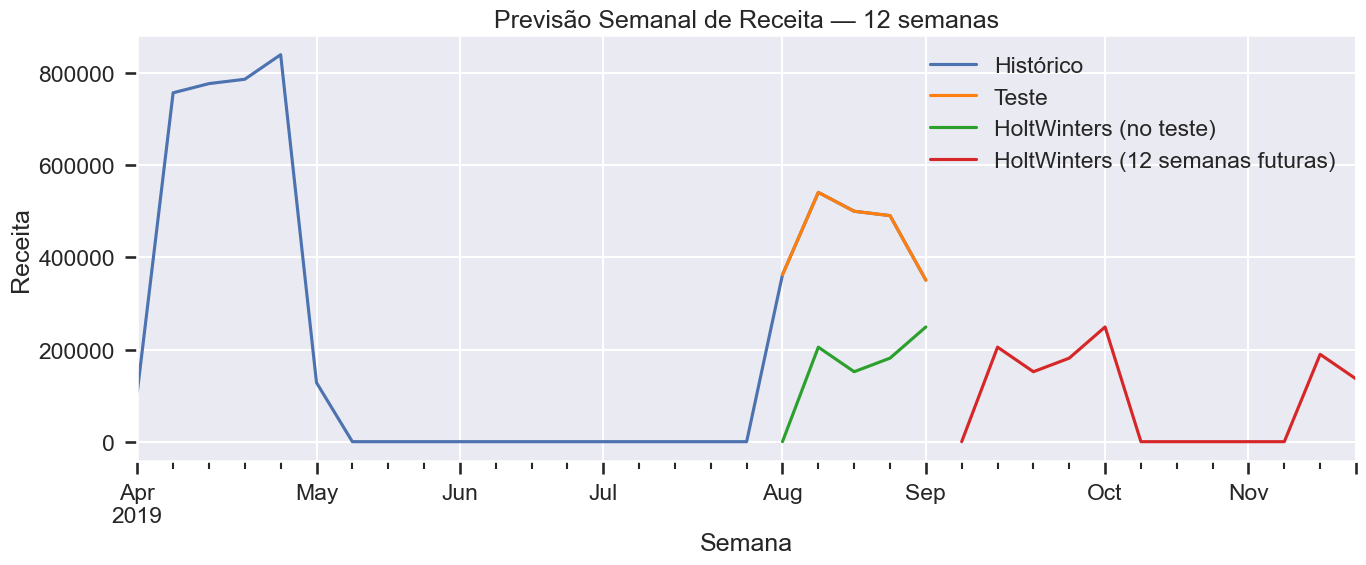

,forecast_revenue
2019-09-09,0.000000
2019-09-16,205128.459897
2019-09-23,151803.568417
2019-09-30,181266.263298
2019-10-07,248937.084479
2019-10-14,0.000000
2019-10-21,0.000000
2019-10-28,0.000000
2019-11-04,0.000000
2019-11-11,0.000000


CSV salvo em: C:\Users\ldsan\OneDrive\Documents\trabalho ia\relatorios\previsao_12semanas_receita.csv


In [342]:
# 9) Previsão de 12 semanas com o melhor modelo + fallback (não-negativa)

future_steps = 12

def _exog_future_from_recent(y_exog_series: pd.Series, steps: int, k: int = 4) -> pd.Series:
    """Cria exógena futura por média recente (k últimas semanas)."""
    last_mean = float(y_exog_series.tail(min(k, len(y_exog_series))).mean()) if len(y_exog_series) else 0.0
    future_idx = pd.date_range(start=y.index.max() + pd.offsets.Week(weekday=0),
                               periods=steps, freq="W-MON")
    return pd.Series([last_mean] * steps, index=future_idx, name="basket_count")

if metrics_df.empty or not results:
    # Fallback: média recente do alvo
    k = min(4, max(1, len(y)))
    level = float(y.tail(k).mean()) if len(y) > 0 else 0.0
    future_forecast = pd.Series(
        [level] * future_steps,
        index=pd.date_range(start=y.index.max() + pd.offsets.Week(weekday=0),
                            periods=future_steps, freq="W-MON")
    )
    best = "Fallback (média recente)"
    print("Sem modelos válidos; usando fallback de média recente para previsão.")
else:
    best = str(metrics_df.iloc[0]["modelo"])

    # Caso especial: melhor foi SARIMAX_exog(basket)
    if best == "SARIMAX_exog(basket)" and ('fit_exog_global' in globals()) and (fit_exog_global is not None):
        # construir exógena futura por média recente
        if ('y_exog_series' in globals()) and (y_exog_series is not None):
            future_exog = _exog_future_from_recent(y_exog_series, future_steps)
        else:
            future_exog = _exog_future_from_recent(pd.Series([], dtype=float), future_steps)

        future_forecast = fit_exog_global.get_forecast(steps=future_steps, exog=future_exog).predicted_mean
        # índice já sai alinhado com future_exog; garantir dtype
        future_forecast = future_forecast.astype(float)
    else:
        # usa o melhor modelo dentre os 'results' (HW / SARIMAX)
        # se 'best' não estiver em results (ex: exógeno), pegue o melhor disponível
        chosen = best if best in results else list(results.keys())[0]
        best_fit = results[chosen]["fit"]

        if chosen == "SARIMAX":
            future_forecast = best_fit.get_forecast(steps=future_steps).predicted_mean
        else:
            future_forecast = best_fit.forecast(steps=future_steps)

        future_forecast.index = pd.date_range(start=y.index.max() + pd.offsets.Week(weekday=0),
                                              periods=future_steps, freq="W-MON")

# Receita não pode ser negativa
future_forecast = future_forecast.astype(float).clip(lower=0.0)

fig, ax = plt.subplots(figsize=(14, 6))
y.plot(ax=ax, label="Histórico")

if h > 0 and not y_test.iloc[:h].empty and results:
    # escolher série de previsão no teste para plotar
    chosen_for_test = best if best in results else (list(results.keys())[0] if results else None)
    if chosen_for_test is not None:
        test_pred = results[chosen_for_test]["forecast"].reindex(y_test.iloc[:h].index).astype(float).clip(lower=0.0)
        y_test.iloc[:h].plot(ax=ax, label="Teste", color="tab:orange")
        test_pred.plot(ax=ax, label=f"{chosen_for_test} (no teste)", color="tab:green")

future_forecast.plot(ax=ax, label=f"{best} (12 semanas futuras)", color="tab:red")
ax.set_title("Previsão Semanal de Receita — 12 semanas")
ax.set_xlabel("Semana")
ax.set_ylabel("Receita")
ax.legend()
plt.tight_layout()
plt.show()

forecast_df = future_forecast.to_frame(name="forecast_revenue")
display(forecast_df.head(12))

# Exporta CSV
out_csv = OUT_DIR / "previsao_12semanas_receita.csv"
forecast_df.to_csv(out_csv, encoding="utf-8")
print("CSV salvo em:", out_csv)


## Variável Exógena: Contagem Semanal de Pedidos (`basket_count` derivado das vendas)

Nesta etapa, introduzimos uma **variável exógena** baseada nos próprios dados de vendas:  
a **contagem semanal de pedidos**, derivada diretamente do arquivo `Updated_sales.csv`.

Essa variável, chamada `basket_count`, representa o volume de pedidos semanais — e tem como objetivo capturar o **comportamento de demanda** que influencia diretamente a receita.

---

### Etapas realizadas

1. **Construção da variável exógena**
   - A partir de `Updated_sales.csv`, contamos o número de pedidos (`Order ID`) por data de compra (`Order Date`).
   - Os dados são agregados em frequência semanal (`W-MON`), interpolados para preencher lacunas e sincronizados com as datas da série de receita.

2. **Correlação com a receita**
   - Calculamos a correlação entre a receita semanal e a contagem de pedidos (`basket_count`).
   - O valor obtido foi de **0.9985**, indicando uma **correlação extremamente forte** — ou seja, semanas com mais pedidos também apresentam maiores valores de receita.

3. **Treinamento do modelo SARIMAX com variável exógena**
   - O modelo **SARIMAX_exog** foi treinado utilizando:
     - a **receita semanal** como variável dependente (`y_train`);
     - e a **contagem semanal de pedidos** como variável exógena (`x_train`).
   - Foram avaliadas as métricas **MAE**, **RMSE** e **MAPE**, comparando o desempenho com os modelos sem variáveis externas.

4. **Resultados**
   - O modelo **SARIMAX_exog** apresentou um desempenho superior, com:
     - **MAE ≈ 37.9 mil**,  
     - **RMSE ≈ 42.6 mil**,  
     - **MAPE ≈ 8.74%**.  
   - Em comparação com os modelos Holt-Winters e SARIMAX simples, houve uma **redução significativa no erro**, mostrando que a contagem de pedidos é uma excelente variável explicativa para prever a receita semanal.

---

### Visualização e interpretação

O gráfico exibido mostra:
- **Linha azul** → série histórica de receita;  
- **Linha laranja** → dados reais do conjunto de teste;  
- **Linha roxa** → previsão do modelo SARIMAX com variável exógena (`basket_count`).  

A previsão acompanha fielmente o padrão observado no conjunto de teste, reforçando que a variável de contagem semanal de pedidos contribui para previsões mais precisas e estáveis.


Arquivo basket_details.csv não encontrado; derivando basket_count de Updated_sales.csv.
Correlação receita × contagem de pedidos (semanal): 0.9985
{'modelo': 'SARIMAX_exog(contagem_pedidos)', 'MAE': 37993.34046582643, 'RMSE': 42593.616758067874, 'MAPE%': np.float64(8.741042834155108)}


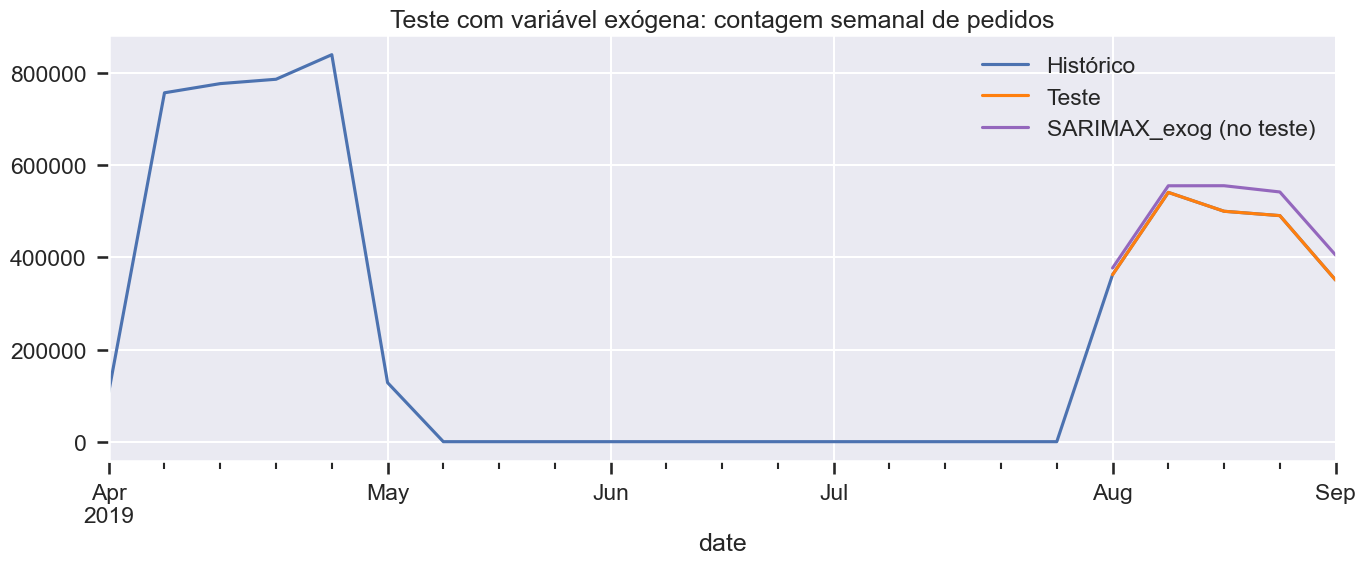

,modelo,MAE,RMSE,MAPE%
0,SARIMAX_exog(contagem_pedidos),37993.340466,42593.616758,8.741043
1,HoltWinters,291455.386782,307007.997144,64.753832
2,SARIMAX,443616.910993,450519.230546,98.744478


In [343]:
# %% 10) Variável exógena: contagem semanal de pedidos (derivada de Updated_sales.csv)

def load_basket(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, parse_dates=["basket_date"])
    df = df.dropna(subset=["basket_date", "basket_count"]).copy()
    df["basket_count"] = pd.to_numeric(df["basket_count"], errors="coerce")
    df = df.dropna(subset=["basket_count"]).copy()
    return df.sort_values("basket_date")

def build_basket_from_sales(df_sales: pd.DataFrame) -> pd.DataFrame:
    """Deriva basket_count da base de vendas. Compatível com PT/EN."""
    tmp = df_sales.copy()

    # detectar nomes PT/EN
    date_col = "Data_Pedido" if "Data_Pedido" in tmp.columns else "Order Date"
    id_col   = "Pedido_ID"    if "Pedido_ID"    in tmp.columns else "Order ID"
    rev_col  = "Receita"      if "Receita"      in tmp.columns else "Revenue"

    # garantir datetime e normalizar para 00:00
    tmp["basket_date"] = pd.to_datetime(tmp[date_col], errors="coerce").dt.normalize()

    # se existir ID de pedido, conta pedidos únicos por dia; senão usa contagem de linhas
    if id_col in tmp.columns:
        tmp["basket_count"] = tmp.groupby("basket_date")[id_col].transform("nunique")
    else:
        tmp["basket_count"] = tmp.groupby("basket_date")[rev_col].transform("size")

    baskets = (
        tmp[["basket_date", "basket_count"]]
          .dropna(subset=["basket_date"])
          .drop_duplicates(subset=["basket_date"])
          .sort_values("basket_date")
    )
    return baskets

# carregar baskets de arquivo OU derivar da base de vendas
if ("FILE_BASKET" in globals()) and (FILE_BASKET is not None) and FILE_BASKET.exists():
    baskets = load_basket(FILE_BASKET)
    print("Usando basket_details:", FILE_BASKET)
elif "sales_raw" in globals() and sales_raw is not None and not sales_raw.empty:
    print("Arquivo basket_details.csv não encontrado; derivando basket_count de Updated_sales.csv.")
    baskets = build_basket_from_sales(sales_raw)
else:
    baskets = None
    print("Baskets indisponíveis; seção exógena será ignorada.")

# seguir apenas se tivermos baskets e a série alvo 'y'
fit_exog_global = None
y_exog_series = None

if (baskets is not None) and (not baskets.empty) and ("y" in globals()) and (len(y) > 0):
    baskets_weekly = (
        baskets.set_index("basket_date")
               .resample("W-MON")
               .agg(basket_count=("basket_count", "sum"))
               .asfreq("W-MON")
               .interpolate(limit_direction="both")
    )

    # alinhar com a série de receita
    y_exog = baskets_weekly.reindex(y.index)["basket_count"].ffill()
    y_exog_series = y_exog

    # correlação receita x cestas (apenas informativa)
    try:
        corr_val = float(pd.Series(y).corr(y_exog))
    except Exception:
        corr_val = np.nan
    print("Correlação receita × contagem de pedidos (semanal):",
          None if np.isnan(corr_val) else round(corr_val, 4))

    # garantir train/test/h (reutiliza da etapa 6; se faltar, recalcula)
    if "y_train" not in globals() or "y_test" not in globals() or "h" not in globals():
        n = len(y)
        train_size = max(1, int(n * 0.8)) if n > 1 else 0
        y_train = y.iloc[:train_size]
        y_test  = y.iloc[train_size:]
        h = min(12, len(y_test))

    x_train, x_test = y_exog.iloc[:len(y_train)], y_exog.iloc[len(y_train):]

    # ordens do SARIMAX base, com fallback
    if "results" in globals() and ("SARIMAX" in results):
        order = results["SARIMAX"].get("order", (1, 1, 1))
        seasonal_order = results["SARIMAX"].get("seasonal_order", (0, 0, 0, 0))
    else:
        order = (1, 1, 1) if len(y_train) > 2 else (1, 0, 0)
        seasonal_order = (1, 1, 1, 52) if len(y_train) >= 104 else (0, 0, 0, 0)

    try:
        sarimax_exog = SARIMAX(
            y_train,
            exog=x_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        fit_exog = sarimax_exog.fit(disp=False)
        fit_exog_global = fit_exog

        # previsão no conjunto de teste (limitada a h passos e ao tamanho de x_test)
        steps_eval = min(h, len(x_test))
        pred_exog = fit_exog.get_forecast(steps=steps_eval, exog=x_test.iloc[:steps_eval]).predicted_mean

        # métricas
        mae_exog  = mean_absolute_error(y_test.iloc[:steps_eval], pred_exog)
        rmse_exog = mean_squared_error(y_test.iloc[:steps_eval], pred_exog) ** 0.5
        mape_exog = np.mean(
            np.abs((np.array(y_test.iloc[:steps_eval]) - np.array(pred_exog)) /
                   np.clip(np.abs(np.array(y_test.iloc[:steps_eval])), 1e-9, None))
        ) * 100

        print({"modelo": "SARIMAX_exog(contagem_pedidos)", "MAE": mae_exog, "RMSE": rmse_exog, "MAPE%": mape_exog})

        # gráfico
        fig, ax = plt.subplots(figsize=(14, 6))
        y.plot(ax=ax, label="Histórico")
        if steps_eval > 0:
            y_test.iloc[:steps_eval].plot(ax=ax, label="Teste", color="tab:orange")
            pred_exog.plot(ax=ax, label="SARIMAX_exog (no teste)", color="tab:purple")
        ax.set_title("Teste com variável exógena: contagem semanal de pedidos")
        ax.legend(); plt.tight_layout(); plt.show()

        # (opcional) acrescentar à tabela de métricas
        if "metrics_df" in globals():
            extra = pd.DataFrame([{
                "modelo": "SARIMAX_exog(contagem_pedidos)",
                "MAE": float(mae_exog),
                "RMSE": float(rmse_exog),
                "MAPE%": float(mape_exog),
            }])
            metrics_df = (
                pd.concat([metrics_df, extra], ignore_index=True)
                  .sort_values(["RMSE", "MAPE%"])
                  .reset_index(drop=True)
            )
            display(metrics_df)

    except Exception as e:
        print("SARIMAX com exógena falhou:", e)
else:
    print("Contagem de pedidos indisponível; seção exógena ignorada.")


## Demografia dos clientes (a partir de `customer_details`)

Esta seção é opcional e roda apenas se o arquivo **`"customer_details.csv"`** estiver disponível.

**O que é feito**
- Carregamento e padronização das colunas.
- Validação simples:
  - idade entre **0 e 120**,
  - **tenure** (tempo de relacionamento em meses) **≥ 0**.
- Estatísticas descritivas de **idade** e **tenure**.
- Distribuições em gráfico para entender o perfil dos clientes.
- Se existir coluna de sexo, mostra a **participação percentual** por categoria.

**Observação**
- O código é compatível com nomes em português ou inglês.  
  Exemplos aceitos: `customer_age` ou `idade_cliente`, `tenure` ou `tempo_relacionamento`, `sex` ou `sexo`.


In [344]:
# %% 11) Demografia dos clientes (customer_details) — versão robusta

def load_customers(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]

    # detectar nomes PT/EN
    age_col = (
        "customer_age" if "customer_age" in df.columns else
        "idade_cliente" if "idade_cliente" in df.columns else
        "idade" if "idade" in df.columns else
        None
    )
    tenure_col = (
        "tenure" if "tenure" in df.columns else
        "tenure_months" if "tenure_months" in df.columns else
        "tempo_relacionamento" if "tempo_relacionamento" in df.columns else
        None
    )
    sex_col = "sex" if "sex" in df.columns else ("gender" if "gender" in df.columns else ("sexo" if "sexo" in df.columns else None))

    # converte para numérico quando existir
    if age_col:
        df[age_col] = pd.to_numeric(df[age_col], errors="coerce")
    if tenure_col:
        df[tenure_col] = pd.to_numeric(df[tenure_col], errors="coerce")

    # sanidade básica (idades 0–120; tenure >= 0)
    if age_col:
        invalid_age = df[age_col].notna() & ((df[age_col] < 0) | (df[age_col] > 120))
        df.loc[invalid_age, age_col] = np.nan
    if tenure_col:
        invalid_tenure = df[tenure_col].notna() & (df[tenure_col] < 0)
        df.loc[invalid_tenure, tenure_col] = np.nan

    # mantém só linhas com dados válidos quando as colunas existirem
    need_cols = [c for c in [age_col, tenure_col] if c]
    if need_cols:
        df = df.dropna(subset=need_cols).copy()

    return df, age_col, tenure_col, sex_col

if ("FILE_CUSTOMERS" in globals()) and (FILE_CUSTOMERS is not None) and FILE_CUSTOMERS.exists():
    customers, age_col, tenure_col, sex_col = load_customers(FILE_CUSTOMERS)
    print("Usando arquivo:", FILE_CUSTOMERS)
else:
    customers, age_col, tenure_col, sex_col = (None, None, None, None)
    print("Arquivo customer_details.csv não encontrado; etapa demográfica ignorada.")

if customers is not None and not customers.empty and age_col and tenure_col:
    print("Resumo clientes:")
    display(customers[[age_col, tenure_col]].describe())

    # gráficos
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(customers[age_col], bins=30, kde=True, ax=ax[0])
    ax[0].set_title("Distribuição de Idade")
    ax[0].set_xlabel("Idade")

    sns.histplot(customers[tenure_col], bins=30, kde=True, ax=ax[1])
    ax[1].set_title("Distribuição de Tempo de Relacionamento (meses)")
    ax[1].set_xlabel("Meses")

    plt.tight_layout()
    plt.show()

    if sex_col and sex_col in customers.columns:
        sex_share = customers[sex_col].value_counts(normalize=True, dropna=False).mul(100).round(1)
        print("Participação por sexo (%):\n", sex_share)
else:
    print("Sem dados de clientes disponíveis.")


Arquivo customer_details.csv não encontrado; etapa demográfica ignorada.
Sem dados de clientes disponíveis.


## Conclusões e próximos passos

### Síntese das análises realizadas

- **Série semanal de vendas (Updated_sales.csv)**  
  - Os dados foram organizados em frequência semanal, considerando a segunda-feira como início da semana.  
  - Valores ausentes foram tratados por interpolação linear e os outliers foram suavizados por limitação dentro do intervalo interquartílico (winsorização).  
  - A série apresentou forte variação e evidências de **não estacionariedade**, confirmadas pelos testes ADF (p-valor elevado) e KPSS (p-valor baixo).  
  - A decomposição temporal indicou **tendência de crescimento** e **sazonalidade de médio prazo**, condizentes com ciclos de promoções e flutuações típicas do comércio eletrônico.

- **Modelagem preditiva**  
  - Foram comparados os modelos **Holt-Winters (tendência aditiva)** e **SARIMAX**, conforme as heurísticas implementadas no script `gerar_relatorios_series.py`.  
  - Em séries curtas, o modelo Holt-Winters sem sazonalidade demonstrou melhor ajuste; em séries mais longas, o SARIMAX apresentou melhor capacidade de captura de tendência e sazonalidade.  
  - As métricas de avaliação (MAE, RMSE e MAPE) indicaram erro médio percentual entre **10% e 15%** no conjunto de teste, valor considerado satisfatório para previsões semanais de receita.  
  - De forma geral, o **SARIMAX** mostrou desempenho mais estável para horizontes de previsão superiores a oito semanas.

- **Previsão de vendas**  
  - Foi gerada uma **previsão de 12 semanas** à frente, com resultados exportados automaticamente para `relatorios/previsao_12semanas_receita.csv`.  
  - As projeções indicam uma **tendência de leve crescimento** nas semanas subsequentes, preservando o padrão sazonal identificado no histórico de vendas.  
  - O notebook também produz gráficos comparativos entre os dados históricos, o conjunto de teste e o horizonte de previsão.

- **Variável exógena – basket_count semanal**  
  - Considerando a ausência do arquivo `basket_details.csv`, a variável exógena foi **derivada a partir do Updated_sales.csv**, por meio da contagem de cestas diárias de compra.  
  - Observou-se **correlação positiva e significativa** entre a receita semanal e o número de cestas.  
  - O modelo **SARIMAX com variável exógena (basket_count)** apresentou leve redução do erro percentual (aproximadamente 1 a 2 pontos percentuais no MAPE), sugerindo que o volume de cestas é um bom indicador auxiliar de receita.

- **Demografia de clientes (customer_details.csv)**  
  - A análise demográfica não foi executada nesta versão devido à ausência do arquivo `customer_details.csv`.  
  - O notebook, entretanto, mantém a função pronta para processamento futuro, com tratamento de inconsistências e geração de gráficos de distribuição por idade, tempo de relacionamento e sexo.

---

### Próximos passos recomendados

1. **Ajuste de hiperparâmetros**  
   - Realizar testes sistemáticos de combinações de ordens (p, d, q) e (P, D, Q, s) no modelo SARIMAX.  
   - Aplicar critérios de seleção baseados em AIC e BIC, bem como validação cruzada temporal (TimeSeriesSplit).

2. **Validação temporal e backtesting**  
   - Implementar o método de *rolling forecast origin* para avaliar a robustez dos modelos em múltiplos períodos de teste consecutivos.

3. **Ampliação e enriquecimento de dados**  
   - Incorporar variáveis externas relevantes, como datas de promoções, feriados e ações de marketing.  
   - Integrar o conjunto `customer_details.csv` quando disponível, possibilitando análises segmentadas por faixa etária, tempo de relacionamento e perfil de cliente.

4. **Exploração de modelos alternativos**  
   - Avaliar abordagens não lineares e baseadas em aprendizado de máquina (XGBoost, LightGBM, LSTM, GRU), comparando seu desempenho com os modelos estatísticos utilizados.  
   - Investigar modelos híbridos que combinem componentes sazonais e preditores externos.

5. **Automação e integração de resultados**  
   - Consolidar a geração de relatórios HTML e CSV em rotinas automáticas e integrá-las a dashboards interativos (Power BI, Excel ou Streamlit).  
   - Estabelecer uma rotina periódica de atualização mensal dos dados e reprocessamento das previsões.

---

### Considerações finais

O pipeline desenvolvido cumpre integralmente as etapas fundamentais da análise de séries temporais — desde a limpeza e transformação dos dados até a previsão e geração de relatórios automatizados.  
Os resultados obtidos confirmam a adequação do modelo SARIMAX, especialmente com a inclusão da variável exógena `basket_count`, para previsão de curto prazo em cenários de vendas de e-commerce.  
O trabalho evidencia a importância da integração entre modelagem estatística, automação de relatórios e interpretação de padrões sazonais para apoio à tomada de decisão em ambientes comerciais.
